
<h1 align=center><font size = 5>Identify high-potential new venues in the Neighborhoods of New York City</font></h1>


## Introduction

This notebook builds up ontop of the existing neighborhood clustering:
We will use the Foursquare API to explore neighborhoods in New York City and cluster them as previously in the course.
After that, we identify a business need for new venues in the neighborhoods.


## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Download and Explore Dataset</a>

2.  <a href="#item2">Explore Neighborhoods in New York City</a>

3.  <a href="#item3">Analyze Each Neighborhood</a>

4.  <a href="#item4">Cluster Neighborhoods</a>

5.  <a href="#item5">Examine Clusters</a>  
    
6.  <a href="#item6">Identify promising new venues in neighborhoods</a>      
    </font>
    </div>


Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [1]:
!pip install folium

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 94 kB 4.5 MB/s  eta 0:00:01
Libraries imported.


<a id='item1'></a>


## 1. Download and Explore Dataset


Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 


For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.


In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


#### Load and explore the data


Next, let's load the data.


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.


In [4]:
#newyork_data

Notice how all the relevant data is in the _features_ key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.


In [5]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.


In [6]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a _pandas_ dataframe


The next task is essentially transforming this data of nested Python dictionaries into a _pandas_ dataframe. So let's start by creating an empty dataframe.


In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.


In [8]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.


In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.


In [10]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.


In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.


In [12]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.


In [13]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.


However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.


In [14]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.


In [15]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


As we did with all of New York City, let's visualizat Manhattan the neighborhoods in it.


In [16]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.


#### Define Foursquare Credentials and Version


In [17]:
CLIENT_ID = 'APFYWPZVIGK3N1WCDHLC5DGC5IHZRSBOBORMXYFOH2HSS0LT' # your Foursquare ID
CLIENT_SECRET = 'HC0MWDMJ1OX50A0LRCV1RAUXSC1TFKTZE0YRVCD5JXQNTYIO' # your Foursquare Secret
ACCESS_TOKEN = 'PLYZURSZ2NMSPQC0SPDKYQZGXFU4HIY0RDHD50S2ZUIPDBGJ' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: APFYWPZVIGK3N1WCDHLC5DGC5IHZRSBOBORMXYFOH2HSS0LT
CLIENT_SECRET:HC0MWDMJ1OX50A0LRCV1RAUXSC1TFKTZE0YRVCD5JXQNTYIO


#### Let's explore the first neighborhood in our dataframe.


Get the neighborhood's name.


In [18]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.


In [19]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.


First, let's create the GET request URL. Name your URL **url**.


In [20]:
# type your answer here

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

 # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=APFYWPZVIGK3N1WCDHLC5DGC5IHZRSBOBORMXYFOH2HSS0LT&client_secret=HC0MWDMJ1OX50A0LRCV1RAUXSC1TFKTZE0YRVCD5JXQNTYIO&v=20180605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

Double-click **here** for the solution.

<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 


Send the GET request and examine the resutls


In [21]:
results = requests.get(url).json()
#results[0]

From the Foursquare lab in the previous module, we know that all the information is in the _items_ key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.


In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.


In [23]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,Diner,40.880404,-73.908937
3,Starbucks,Coffee Shop,40.877531,-73.905582
4,Dunkin',Donut Shop,40.877136,-73.906666


And how many venues were returned by Foursquare?


In [24]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

24 venues were returned by Foursquare.


<a id='item2'></a>


## 2. Explore Neighborhoods in Manhattan


#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan


In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _manhattan_venues_.


In [26]:
# type your answer here
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Double-click **here** for the solution.

<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 


#### Let's check the size of the resulting dataframe


In [27]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3200, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


Let's check how many venues were returned for each neighborhood


In [28]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,73,73,73,73,73,73
Carnegie Hill,90,90,90,90,90,90
Central Harlem,45,45,45,45,45,45
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,39,39,39,39,39,39
East Village,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues


In [29]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 330 uniques categories.


<a id='item3'></a>


## 3. Analyze Each Neighborhood


In [30]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Sob

And let's examine the new dataframe size.


In [31]:
manhattan_onehot.shape

(3200, 331)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [32]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Sob

#### Let's confirm the new size


In [33]:
manhattan_grouped.shape

(40, 331)

#### Let's print each neighborhood along with the top 5 most common venues


In [34]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
            venue  freq
0     Coffee Shop  0.08
1            Park  0.07
2           Hotel  0.07
3  Clothing Store  0.05
4   Memorial Site  0.04


----Carnegie Hill----
         venue  freq
0  Coffee Shop  0.09
1         Café  0.04
2  Yoga Studio  0.03
3  Pizza Place  0.03
4          Gym  0.03


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1  American Restaurant  0.04
2                  Bar  0.04
3   Seafood Restaurant  0.04
4       Cosmetics Shop  0.04


----Chelsea----
                venue  freq
0         Coffee Shop  0.06
1         Art Gallery  0.06
2              Bakery  0.04
3  Seafood Restaurant  0.03
4           Wine Shop  0.03


----Chinatown----
                venue  freq
0  Chinese Restaurant  0.07
1              Bakery  0.07
2        Cocktail Bar  0.04
3     Bubble Tea Shop  0.03
4        Dessert Shop  0.03


----Civic Center----
                  venue  freq
0           Coffee Shop  0.07
1  Gym / Fitness Center 

#### Let's put that into a _pandas_ dataframe


First, let's write a function to sort the venues in descending order.


In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [36]:
num_top_venues = 300

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue,36th Most Common Venue,37th Most Common Venue,38th Most Common Venue,39th Most Common Venue,40th Most Common Venue,41th Most Common Venue,42th Most Common Venue,43th Most Common Venue,44th Most Common Venue,45th Most Common Venue,46th Most Common Venue,47th Most Common Venue,48th Most Common Venue,49th Most Common Venue,50th Most Common Venue,51th Most Common Venue,52th Most Common Venue,53th Most Common Venue,54th Most Common Venue,55th Most Common Venue,56th Most Common Venue,57th Most Common Venue,58th Most Common Venue,59th Most Common Venue,60th Most Common Venue,61th Most Common Venue,62th Most Common Venue,63th Most Common Venue,64th Most Common Venue,65th Most Common Venue,66th Most Common Venue,67th Most Common Venue,68th Most Common Venue,69th Most Common Venue,70th Most Common Venue,71th Most Common Venue,72th Most Common Venue,73th Most Common Venue,74th Most Common Venue,75th Most Common Venue,76th Most Common Venue,77th Most Common Venue,78th Most Common Venue,79th Most Common Venue,80th Most Common Venue,81th Most Common Venue,82th Most Common Venue,83th Most Common Venue,84th Most Common Venue,85th Most Common Venue,86th Most Common Venue,87th Most Common Venue,88th Most Common Venue,89th Most Common Venue,90th Most Common Venue,91th Most Common Venue,92th Most Common Venue,93th Most Common Venue,94th Most Common Venue,95th Most Common Venue,96th Most Common Venue,97th Most Common Venue,98th Most Common Venue,99th Most Common Venue,100th Most Common Venue,101th Most Common Venue,102th Most Common Venue,103th Most Common Venue,104th Most Common Venue,105th Most Common Venue,106th Most Common Venue,107th Most Common Venue,108th Most Common Venue,109th Most Common Venue,110th Most Common Venue,111th Most Common Venue,112th Most Common Venue,113th Most Common Venue,114th Most Common Venue,115th Most Common Venue,116th Most Common Venue,117th Most Common Venue,118th Most Common Venue,119th Most Common Venue,120th Most Common Venue,121th Most Common Venue,122th Most Common Venue,123th Most Common Venue,124th Most Common Venue,125th Most Common Venue,126th Most Common Venue,127th Most Common Venue,128th Most Common Venue,129th Most Common Venue,130th Most Common Venue,131th Most Common Venue,132th Most Common Venue,133th Most Common Venue,134th Most Common Venue,135th Most Common Venue,136th Most Common Venue,137th Most Common Venue,138th Most Common Venue,139th Most Common Venue,140th Most Common Venue,141th Most Common Venue,142th Most Common Venue,143th Most Common Venue,144th Most Common Venue,145th Most Common Venue,146th Most Common Venue,147th Most Common Venue,148th Most Common Venue,149th Most Common Venue,150th Most Common Venue,151th Most Common Venue,152th Most Common Venue,153th Most Common Venue,154th Most Common Venue,155th Most Common Venue,156th Most Common Venue,157th Most Common Venue,158th Most Common Venue,159th Most Common Venue,160th Most Common Venue,161th Most Common Venue,162th Most Common Venue,163th Most Common Venue,164th Most Common Venue,165th Most Common Venue,166th Most Common Venue,167th Most Common Venue,168th Most Common Venue,169th Most Common Venue,170th Most Common Venue,171th Most Com

<a id='item4'></a>


## 4. Cluster Neighborhoods


Run _k_-means to cluster the neighborhood into 5 clusters.


In [37]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 0, 0, 1, 1, 3, 0, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue,36th Most Common Venue,37th Most Common Venue,38th Most Common Venue,39th Most Common Venue,40th Most Common Venue,41th Most Common Venue,42th Most Common Venue,43th Most Common Venue,44th Most Common Venue,45th Most Common Venue,46th Most Common Venue,47th Most Common Venue,48th Most Common Venue,49th Most Common Venue,50th Most Common Venue,51th Most Common Venue,52th Most Common Venue,53th Most Common Venue,54th Most Common Venue,55th Most Common Venue,56th Most Common Venue,57th Most Common Venue,58th Most Common Venue,59th Most Common Venue,60th Most Common Venue,61th Most Common Venue,62th Most Common Venue,63th Most Common Venue,64th Most Common Venue,65th Most Common Venue,66th Most Common Venue,67th Most Common Venue,68th Most Common Venue,69th Most Common Venue,70th Most Common Venue,71th Most Common Venue,72th Most Common Venue,73th Most Common Venue,74th Most Common Venue,75th Most Common Venue,76th Most Common Venue,77th Most Common Venue,78th Most Common Venue,79th Most Common Venue,80th Most Common Venue,81th Most Common Venue,82th Most Common Venue,83th Most Common Venue,84th Most Common Venue,85th Most Common Venue,86th Most Common Venue,87th Most Common Venue,88th Most Common Venue,89th Most Common Venue,90th Most Common Venue,91th Most Common Venue,92th Most Common Venue,93th Most Common Venue,94th Most Common Venue,95th Most Common Venue,96th Most Common Venue,97th Most Common Venue,98th Most Common Venue,99th Most Common Venue,100th Most Common Venue,101th Most Common Venue,102th Most Common Venue,103th Most Common Venue,104th Most Common Venue,105th Most Common Venue,106th Most Common Venue,107th Most Common Venue,108th Most Common Venue,109th Most Common Venue,110th Most Common Venue,111th Most Common Venue,112th Most Common Venue,113th Most Common Venue,114th Most Common Venue,115th Most Common Venue,116th Most Common Venue,117th Most Common Venue,118th Most Common Venue,119th Most Common Venue,120th Most Common Venue,121th Most Common Venue,122th Most Common Venue,123th Most Common Venue,124th Most Common Venue,125th Most Common Venue,126th Most Common Venue,127th Most Common Venue,128th Most Common Venue,129th Most Common Venue,130th Most Common Venue,131th Most Common Venue,132th Most Common Venue,133th Most Common Venue,134th Most Common Venue,135th Most Common Venue,136th Most Common Venue,137th Most Common Venue,138th Most Common Venue,139th Most Common Venue,140th Most Common Venue,141th Most Common Venue,142th Most Common Venue,143th Most Common Venue,144th Most Common Venue,145th Most Common Venue,146th Most Common Venue,147th Most Common Venue,148th Most Common Venue,149th Most Common Venue,150th Most Common Venue,151th Most Common Venue,152th Most Common Venue,153th Most Common Venue,154th Most Common Venue,155th Most Common Venue,156th Most Common Venue,157th Most Common Venue,158th Most Common Venue,159th Most Common Venue,160th Most Common Venue,161th Most Common Venue,162th Most Common Venue,163th Most Common Venue,164th Most Common Venue,165th Most Common Venue,166th Most Common Venue,167th Most Common Venue,168th Most Common Venue,169th Most Common Ve

Finally, let's visualize the resulting clusters


In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>


## 5. Examine Clusters


Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.


#### Cluster 1


In [40]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue,36th Most Common Venue,37th Most Common Venue,38th Most Common Venue,39th Most Common Venue,40th Most Common Venue,41th Most Common Venue,42th Most Common Venue,43th Most Common Venue,44th Most Common Venue,45th Most Common Venue,46th Most Common Venue,47th Most Common Venue,48th Most Common Venue,49th Most Common Venue,50th Most Common Venue,51th Most Common Venue,52th Most Common Venue,53th Most Common Venue,54th Most Common Venue,55th Most Common Venue,56th Most Common Venue,57th Most Common Venue,58th Most Common Venue,59th Most Common Venue,60th Most Common Venue,61th Most Common Venue,62th Most Common Venue,63th Most Common Venue,64th Most Common Venue,65th Most Common Venue,66th Most Common Venue,67th Most Common Venue,68th Most Common Venue,69th Most Common Venue,70th Most Common Venue,71th Most Common Venue,72th Most Common Venue,73th Most Common Venue,74th Most Common Venue,75th Most Common Venue,76th Most Common Venue,77th Most Common Venue,78th Most Common Venue,79th Most Common Venue,80th Most Common Venue,81th Most Common Venue,82th Most Common Venue,83th Most Common Venue,84th Most Common Venue,85th Most Common Venue,86th Most Common Venue,87th Most Common Venue,88th Most Common Venue,89th Most Common Venue,90th Most Common Venue,91th Most Common Venue,92th Most Common Venue,93th Most Common Venue,94th Most Common Venue,95th Most Common Venue,96th Most Common Venue,97th Most Common Venue,98th Most Common Venue,99th Most Common Venue,100th Most Common Venue,101th Most Common Venue,102th Most Common Venue,103th Most Common Venue,104th Most Common Venue,105th Most Common Venue,106th Most Common Venue,107th Most Common Venue,108th Most Common Venue,109th Most Common Venue,110th Most Common Venue,111th Most Common Venue,112th Most Common Venue,113th Most Common Venue,114th Most Common Venue,115th Most Common Venue,116th Most Common Venue,117th Most Common Venue,118th Most Common Venue,119th Most Common Venue,120th Most Common Venue,121th Most Common Venue,122th Most Common Venue,123th Most Common Venue,124th Most Common Venue,125th Most Common Venue,126th Most Common Venue,127th Most Common Venue,128th Most Common Venue,129th Most Common Venue,130th Most Common Venue,131th Most Common Venue,132th Most Common Venue,133th Most Common Venue,134th Most Common Venue,135th Most Common Venue,136th Most Common Venue,137th Most Common Venue,138th Most Common Venue,139th Most Common Venue,140th Most Common Venue,141th Most Common Venue,142th Most Common Venue,143th Most Common Venue,144th Most Common Venue,145th Most Common Venue,146th Most Common Venue,147th Most Common Venue,148th Most Common Venue,149th Most Common Venue,150th Most Common Venue,151th Most Common Venue,152th Most Common Venue,153th Most Common Venue,154th Most Common Venue,155th Most Common Venue,156th Most Common Venue,157th Most Common Venue,158th Most Common Venue,159th Most Common Venue,160th Most Common Venue,161th Most Common Venue,162th Most Common Venue,163th Most Common Venue,164th Most Common Venue,165th Most Common Venue,166th Most Common Venue,167th Most Common Venue,168th Most Common Venue,169th Most Common Venue,170th Most Common Venue,171th Most Com

#### Cluster 2


In [41]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue,36th Most Common Venue,37th Most Common Venue,38th Most Common Venue,39th Most Common Venue,40th Most Common Venue,41th Most Common Venue,42th Most Common Venue,43th Most Common Venue,44th Most Common Venue,45th Most Common Venue,46th Most Common Venue,47th Most Common Venue,48th Most Common Venue,49th Most Common Venue,50th Most Common Venue,51th Most Common Venue,52th Most Common Venue,53th Most Common Venue,54th Most Common Venue,55th Most Common Venue,56th Most Common Venue,57th Most Common Venue,58th Most Common Venue,59th Most Common Venue,60th Most Common Venue,61th Most Common Venue,62th Most Common Venue,63th Most Common Venue,64th Most Common Venue,65th Most Common Venue,66th Most Common Venue,67th Most Common Venue,68th Most Common Venue,69th Most Common Venue,70th Most Common Venue,71th Most Common Venue,72th Most Common Venue,73th Most Common Venue,74th Most Common Venue,75th Most Common Venue,76th Most Common Venue,77th Most Common Venue,78th Most Common Venue,79th Most Common Venue,80th Most Common Venue,81th Most Common Venue,82th Most Common Venue,83th Most Common Venue,84th Most Common Venue,85th Most Common Venue,86th Most Common Venue,87th Most Common Venue,88th Most Common Venue,89th Most Common Venue,90th Most Common Venue,91th Most Common Venue,92th Most Common Venue,93th Most Common Venue,94th Most Common Venue,95th Most Common Venue,96th Most Common Venue,97th Most Common Venue,98th Most Common Venue,99th Most Common Venue,100th Most Common Venue,101th Most Common Venue,102th Most Common Venue,103th Most Common Venue,104th Most Common Venue,105th Most Common Venue,106th Most Common Venue,107th Most Common Venue,108th Most Common Venue,109th Most Common Venue,110th Most Common Venue,111th Most Common Venue,112th Most Common Venue,113th Most Common Venue,114th Most Common Venue,115th Most Common Venue,116th Most Common Venue,117th Most Common Venue,118th Most Common Venue,119th Most Common Venue,120th Most Common Venue,121th Most Common Venue,122th Most Common Venue,123th Most Common Venue,124th Most Common Venue,125th Most Common Venue,126th Most Common Venue,127th Most Common Venue,128th Most Common Venue,129th Most Common Venue,130th Most Common Venue,131th Most Common Venue,132th Most Common Venue,133th Most Common Venue,134th Most Common Venue,135th Most Common Venue,136th Most Common Venue,137th Most Common Venue,138th Most Common Venue,139th Most Common Venue,140th Most Common Venue,141th Most Common Venue,142th Most Common Venue,143th Most Common Venue,144th Most Common Venue,145th Most Common Venue,146th Most Common Venue,147th Most Common Venue,148th Most Common Venue,149th Most Common Venue,150th Most Common Venue,151th Most Common Venue,152th Most Common Venue,153th Most Common Venue,154th Most Common Venue,155th Most Common Venue,156th Most Common Venue,157th Most Common Venue,158th Most Common Venue,159th Most Common Venue,160th Most Common Venue,161th Most Common Venue,162th Most Common Venue,163th Most Common Venue,164th Most Common Venue,165th Most Common Venue,166th Most Common Venue,167th Most Common Venue,168th Most Common Venue,169th Most Common Venue,170th Most Common Venue,171th Most Com

#### Cluster 3


In [42]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue,36th Most Common Venue,37th Most Common Venue,38th Most Common Venue,39th Most Common Venue,40th Most Common Venue,41th Most Common Venue,42th Most Common Venue,43th Most Common Venue,44th Most Common Venue,45th Most Common Venue,46th Most Common Venue,47th Most Common Venue,48th Most Common Venue,49th Most Common Venue,50th Most Common Venue,51th Most Common Venue,52th Most Common Venue,53th Most Common Venue,54th Most Common Venue,55th Most Common Venue,56th Most Common Venue,57th Most Common Venue,58th Most Common Venue,59th Most Common Venue,60th Most Common Venue,61th Most Common Venue,62th Most Common Venue,63th Most Common Venue,64th Most Common Venue,65th Most Common Venue,66th Most Common Venue,67th Most Common Venue,68th Most Common Venue,69th Most Common Venue,70th Most Common Venue,71th Most Common Venue,72th Most Common Venue,73th Most Common Venue,74th Most Common Venue,75th Most Common Venue,76th Most Common Venue,77th Most Common Venue,78th Most Common Venue,79th Most Common Venue,80th Most Common Venue,81th Most Common Venue,82th Most Common Venue,83th Most Common Venue,84th Most Common Venue,85th Most Common Venue,86th Most Common Venue,87th Most Common Venue,88th Most Common Venue,89th Most Common Venue,90th Most Common Venue,91th Most Common Venue,92th Most Common Venue,93th Most Common Venue,94th Most Common Venue,95th Most Common Venue,96th Most Common Venue,97th Most Common Venue,98th Most Common Venue,99th Most Common Venue,100th Most Common Venue,101th Most Common Venue,102th Most Common Venue,103th Most Common Venue,104th Most Common Venue,105th Most Common Venue,106th Most Common Venue,107th Most Common Venue,108th Most Common Venue,109th Most Common Venue,110th Most Common Venue,111th Most Common Venue,112th Most Common Venue,113th Most Common Venue,114th Most Common Venue,115th Most Common Venue,116th Most Common Venue,117th Most Common Venue,118th Most Common Venue,119th Most Common Venue,120th Most Common Venue,121th Most Common Venue,122th Most Common Venue,123th Most Common Venue,124th Most Common Venue,125th Most Common Venue,126th Most Common Venue,127th Most Common Venue,128th Most Common Venue,129th Most Common Venue,130th Most Common Venue,131th Most Common Venue,132th Most Common Venue,133th Most Common Venue,134th Most Common Venue,135th Most Common Venue,136th Most Common Venue,137th Most Common Venue,138th Most Common Venue,139th Most Common Venue,140th Most Common Venue,141th Most Common Venue,142th Most Common Venue,143th Most Common Venue,144th Most Common Venue,145th Most Common Venue,146th Most Common Venue,147th Most Common Venue,148th Most Common Venue,149th Most Common Venue,150th Most Common Venue,151th Most Common Venue,152th Most Common Venue,153th Most Common Venue,154th Most Common Venue,155th Most Common Venue,156th Most Common Venue,157th Most Common Venue,158th Most Common Venue,159th Most Common Venue,160th Most Common Venue,161th Most Common Venue,162th Most Common Venue,163th Most Common Venue,164th Most Common Venue,165th Most Common Venue,166th Most Common Venue,167th Most Common Venue,168th Most Common Venue,169th Most Common Venue,170th Most Common Venue,171th Most Com

#### Cluster 4


In [43]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue,36th Most Common Venue,37th Most Common Venue,38th Most Common Venue,39th Most Common Venue,40th Most Common Venue,41th Most Common Venue,42th Most Common Venue,43th Most Common Venue,44th Most Common Venue,45th Most Common Venue,46th Most Common Venue,47th Most Common Venue,48th Most Common Venue,49th Most Common Venue,50th Most Common Venue,51th Most Common Venue,52th Most Common Venue,53th Most Common Venue,54th Most Common Venue,55th Most Common Venue,56th Most Common Venue,57th Most Common Venue,58th Most Common Venue,59th Most Common Venue,60th Most Common Venue,61th Most Common Venue,62th Most Common Venue,63th Most Common Venue,64th Most Common Venue,65th Most Common Venue,66th Most Common Venue,67th Most Common Venue,68th Most Common Venue,69th Most Common Venue,70th Most Common Venue,71th Most Common Venue,72th Most Common Venue,73th Most Common Venue,74th Most Common Venue,75th Most Common Venue,76th Most Common Venue,77th Most Common Venue,78th Most Common Venue,79th Most Common Venue,80th Most Common Venue,81th Most Common Venue,82th Most Common Venue,83th Most Common Venue,84th Most Common Venue,85th Most Common Venue,86th Most Common Venue,87th Most Common Venue,88th Most Common Venue,89th Most Common Venue,90th Most Common Venue,91th Most Common Venue,92th Most Common Venue,93th Most Common Venue,94th Most Common Venue,95th Most Common Venue,96th Most Common Venue,97th Most Common Venue,98th Most Common Venue,99th Most Common Venue,100th Most Common Venue,101th Most Common Venue,102th Most Common Venue,103th Most Common Venue,104th Most Common Venue,105th Most Common Venue,106th Most Common Venue,107th Most Common Venue,108th Most Common Venue,109th Most Common Venue,110th Most Common Venue,111th Most Common Venue,112th Most Common Venue,113th Most Common Venue,114th Most Common Venue,115th Most Common Venue,116th Most Common Venue,117th Most Common Venue,118th Most Common Venue,119th Most Common Venue,120th Most Common Venue,121th Most Common Venue,122th Most Common Venue,123th Most Common Venue,124th Most Common Venue,125th Most Common Venue,126th Most Common Venue,127th Most Common Venue,128th Most Common Venue,129th Most Common Venue,130th Most Common Venue,131th Most Common Venue,132th Most Common Venue,133th Most Common Venue,134th Most Common Venue,135th Most Common Venue,136th Most Common Venue,137th Most Common Venue,138th Most Common Venue,139th Most Common Venue,140th Most Common Venue,141th Most Common Venue,142th Most Common Venue,143th Most Common Venue,144th Most Common Venue,145th Most Common Venue,146th Most Common Venue,147th Most Common Venue,148th Most Common Venue,149th Most Common Venue,150th Most Common Venue,151th Most Common Venue,152th Most Common Venue,153th Most Common Venue,154th Most Common Venue,155th Most Common Venue,156th Most Common Venue,157th Most Common Venue,158th Most Common Venue,159th Most Common Venue,160th Most Common Venue,161th Most Common Venue,162th Most Common Venue,163th Most Common Venue,164th Most Common Venue,165th Most Common Venue,166th Most Common Venue,167th Most Common Venue,168th Most Common Venue,169th Most Common Venue,170th Most Common Venue,171th Most Com

#### Cluster 5


In [44]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue,36th Most Common Venue,37th Most Common Venue,38th Most Common Venue,39th Most Common Venue,40th Most Common Venue,41th Most Common Venue,42th Most Common Venue,43th Most Common Venue,44th Most Common Venue,45th Most Common Venue,46th Most Common Venue,47th Most Common Venue,48th Most Common Venue,49th Most Common Venue,50th Most Common Venue,51th Most Common Venue,52th Most Common Venue,53th Most Common Venue,54th Most Common Venue,55th Most Common Venue,56th Most Common Venue,57th Most Common Venue,58th Most Common Venue,59th Most Common Venue,60th Most Common Venue,61th Most Common Venue,62th Most Common Venue,63th Most Common Venue,64th Most Common Venue,65th Most Common Venue,66th Most Common Venue,67th Most Common Venue,68th Most Common Venue,69th Most Common Venue,70th Most Common Venue,71th Most Common Venue,72th Most Common Venue,73th Most Common Venue,74th Most Common Venue,75th Most Common Venue,76th Most Common Venue,77th Most Common Venue,78th Most Common Venue,79th Most Common Venue,80th Most Common Venue,81th Most Common Venue,82th Most Common Venue,83th Most Common Venue,84th Most Common Venue,85th Most Common Venue,86th Most Common Venue,87th Most Common Venue,88th Most Common Venue,89th Most Common Venue,90th Most Common Venue,91th Most Common Venue,92th Most Common Venue,93th Most Common Venue,94th Most Common Venue,95th Most Common Venue,96th Most Common Venue,97th Most Common Venue,98th Most Common Venue,99th Most Common Venue,100th Most Common Venue,101th Most Common Venue,102th Most Common Venue,103th Most Common Venue,104th Most Common Venue,105th Most Common Venue,106th Most Common Venue,107th Most Common Venue,108th Most Common Venue,109th Most Common Venue,110th Most Common Venue,111th Most Common Venue,112th Most Common Venue,113th Most Common Venue,114th Most Common Venue,115th Most Common Venue,116th Most Common Venue,117th Most Common Venue,118th Most Common Venue,119th Most Common Venue,120th Most Common Venue,121th Most Common Venue,122th Most Common Venue,123th Most Common Venue,124th Most Common Venue,125th Most Common Venue,126th Most Common Venue,127th Most Common Venue,128th Most Common Venue,129th Most Common Venue,130th Most Common Venue,131th Most Common Venue,132th Most Common Venue,133th Most Common Venue,134th Most Common Venue,135th Most Common Venue,136th Most Common Venue,137th Most Common Venue,138th Most Common Venue,139th Most Common Venue,140th Most Common Venue,141th Most Common Venue,142th Most Common Venue,143th Most Common Venue,144th Most Common Venue,145th Most Common Venue,146th Most Common Venue,147th Most Common Venue,148th Most Common Venue,149th Most Common Venue,150th Most Common Venue,151th Most Common Venue,152th Most Common Venue,153th Most Common Venue,154th Most Common Venue,155th Most Common Venue,156th Most Common Venue,157th Most Common Venue,158th Most Common Venue,159th Most Common Venue,160th Most Common Venue,161th Most Common Venue,162th Most Common Venue,163th Most Common Venue,164th Most Common Venue,165th Most Common Venue,166th Most Common Venue,167th Most Common Venue,168th Most Common Venue,169th Most Common Venue,170th Most Common Venue,171th Most Com

## 6. Identify promising new venues in neighborhoods

look at cluster 1

In [45]:
df = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
df = df.T # transpose date
df.columns = df.iloc[0] # make neighborhoods column names
df['Row Number'] = np.arange(len(df)) # add row number and thus venue rank as number
df = df.iloc[1:] # remove row with neighborhoods

df.head()

Neighborhood,Chinatown,Manhattanville,Central Harlem,Upper East Side,Yorkville,Lenox Hill,Upper West Side,Lincoln Square,Chelsea,Greenwich Village,East Village,Tribeca,Little Italy,Soho,West Village,Manhattan Valley,Gramercy,Noho,Sutton Place,Turtle Bay,Row Number
1st Most Common Venue,Bakery,Seafood Restaurant,African Restaurant,Italian Restaurant,Italian Restaurant,Italian Restaurant,Italian Restaurant,Café,Art Gallery,Italian Restaurant,Bar,Park,Bakery,Clothing Store,Italian Restaurant,Coffee Shop,Bar,Italian Restaurant,Italian Restaurant,Coffee Shop,1
2nd Most Common Venue,Chinese Restaurant,Coffee Shop,Chinese Restaurant,Exhibit,Gym,Coffee Shop,Wine Bar,Plaza,Coffee Shop,Sushi Restaurant,Pizza Place,Italian Restaurant,Bubble Tea Shop,Italian Restaurant,New American Restaurant,Bar,Pizza Place,Coffee Shop,Park,Italian Restaurant,2
3rd Most Common Venue,Cocktail Bar,Italian Restaurant,Bar,Coffee Shop,Coffee Shop,Sushi Restaurant,Bar,Italian Restaurant,Bakery,Clothing Store,Mexican Restaurant,Wine Bar,Café,Boutique,American Restaurant,Yoga Studio,Italian Restaurant,Mexican Restaurant,Pizza Place,Park,3
4th Most Common Venue,Spa,Mexican Restaurant,Seafood Restaurant,Bakery,Sushi Restaurant,Cocktail Bar,Bakery,Concert Hall,American Restaurant,Café,Wine Bar,American Restaurant,Chinese Restaurant,Mediterranean Restaurant,Cocktail Bar,Pizza Place,American Restaurant,Art Gallery,Coffee Shop,Deli / Bodega,4
5th Most Common Venue,Salon / Barbershop,Food & Drink Shop,French Restaurant,Gym / Fitness Center,Bar,Pizza Place,Café,Performing Arts Venue,Wine Shop,American Restaurant,Vietnamese Restaurant,Spa,Hotel,Coffee Shop,Park,Thai Restaurant,Bagel Shop,Grocery Store,Gym / Fitness Center,Japanese Restaurant,5


make list of unique venues

In [46]:
# make a data frame of values in the first column
allvenues = df[df.columns[0]]
allvenues = pd.DataFrame(df[df.columns[0]])
allvenues = allvenues.rename(columns={allvenues.columns[0]: "List"})

# add all values from the other columns
for x in range(1,len(df.columns)-1):
  temp_list = df[df.columns[x]]
  temp_list = pd.DataFrame(temp_list)
  temp_list = temp_list.rename(columns={temp_list.columns[0]: "List"})  
  allvenues = allvenues.append(temp_list, ignore_index=True)

# sort the values
allvenues.sort_values("List", inplace = True) 
  
# dropping duplicte values 
allvenues.drop_duplicates(keep = 'first', inplace = True)

# reset index
allvenues = allvenues.reset_index(drop=True)

# check the list
print(allvenues.shape)
allvenues.head(10)

(330, 1)


,List
0,Accessories Store
1,Adult Boutique
2,Afghan Restaurant
3,African Restaurant
4,American Restaurant
5,Antique Shop
6,Arepa Restaurant
7,Argentinian Restaurant
8,Art Gallery
9,Art Museum


Add Columns for all neighborhoods

In [47]:
# add all neighborhoods as columns
for x in range(0,len(df.columns)-1):
  allvenues[df.columns[x]] = np.nan  
  #print(df.columns[x])

allvenues.head()


,List,Chinatown,Manhattanville,Central Harlem,Upper East Side,Yorkville,Lenox Hill,Upper West Side,Lincoln Square,Chelsea,Greenwich Village,East Village,Tribeca,Little Italy,Soho,West Village,Manhattan Valley,Gramercy,Noho,Sutton Place,Turtle Bay
0,Accessories Store,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Adult Boutique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghan Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,African Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,American Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


for each venue ad its rank 

In [48]:
for row in allvenues['List']:
    #print(row)
    #print('test')
    for column in allvenues.columns[1:]:
        #print(column)
        #print(df[df[column] == row]['Row Number'])
        #newvalue = int( df[df[column] == row]['Row Number'])
        #newvalue = pd.to_numeric( int( df[df[column] == row]['Row Number']) , errors='ignore')
        try:
            newvalue = int( df[df[column] == row]['Row Number'])
        except (RuntimeError, TypeError, NameError):
            #print("Oops!  That was no valid number.  Try again...")
            newvalue = 300
        allvenues.loc[allvenues['List'] == row, [column]]  =  newvalue
        #allvenues[column] = df[df[column] == row]['Row Number'] #np.where(allvenues['List'] == row, df[df[column] == row]['Row Number'], 300)
        
allvenues.head()        

,List,Chinatown,Manhattanville,Central Harlem,Upper East Side,Yorkville,Lenox Hill,Upper West Side,Lincoln Square,Chelsea,Greenwich Village,East Village,Tribeca,Little Italy,Soho,West Village,Manhattan Valley,Gramercy,Noho,Sutton Place,Turtle Bay
0,Accessories Store,300.0,300.0,300.0,300.0,300.0,300.0,49.0,300.0,300.0,56.0,300.0,300.0,300.0,300.0,28.0,300.0,300.0,300.0,300.0,300.0
1,Adult Boutique,92.0,119.0,120.0,87.0,130.0,144.0,155.0,126.0,162.0,160.0,132.0,128.0,130.0,131.0,129.0,118.0,127.0,95.0,45.0,131.0
2,Afghan Restaurant,98.0,120.0,121.0,92.0,131.0,62.0,154.0,127.0,161.0,159.0,133.0,129.0,131.0,132.0,130.0,119.0,128.0,98.0,131.0,132.0
3,African Restaurant,100.0,121.0,1.0,93.0,132.0,143.0,153.0,128.0,160.0,158.0,134.0,130.0,132.0,133.0,131.0,120.0,129.0,99.0,132.0,133.0
4,American Restaurant,10.0,29.0,6.0,11.0,133.0,142.0,21.0,20.0,4.0,5.0,18.0,4.0,133.0,10.0,3.0,121.0,4.0,100.0,8.0,54.0


add average 

In [49]:
allvenues['average'] = allvenues.mean(numeric_only=True, axis=1)
allvenues.head()

,List,Chinatown,Manhattanville,Central Harlem,Upper East Side,Yorkville,Lenox Hill,Upper West Side,Lincoln Square,Chelsea,Greenwich Village,East Village,Tribeca,Little Italy,Soho,West Village,Manhattan Valley,Gramercy,Noho,Sutton Place,Turtle Bay,average
0,Accessories Store,300.0,300.0,300.0,300.0,300.0,300.0,49.0,300.0,300.0,56.0,300.0,300.0,300.0,300.0,28.0,300.0,300.0,300.0,300.0,300.0,261.65
1,Adult Boutique,92.0,119.0,120.0,87.0,130.0,144.0,155.0,126.0,162.0,160.0,132.0,128.0,130.0,131.0,129.0,118.0,127.0,95.0,45.0,131.0,123.05
2,Afghan Restaurant,98.0,120.0,121.0,92.0,131.0,62.0,154.0,127.0,161.0,159.0,133.0,129.0,131.0,132.0,130.0,119.0,128.0,98.0,131.0,132.0,124.40
3,African Restaurant,100.0,121.0,1.0,93.0,132.0,143.0,153.0,128.0,160.0,158.0,134.0,130.0,132.0,133.0,131.0,120.0,129.0,99.0,132.0,133.0,123.10
4,American Restaurant,10.0,29.0,6.0,11.0,133.0,142.0,21.0,20.0,4.0,5.0,18.0,4.0,133.0,10.0,3.0,121.0,4.0,100.0,8.0,54.0,41.80


make score what is needed in each neighborhood

In [50]:
venue_need = allvenues

In [51]:


for column in venue_need.columns[1:]:
    print(column)
    venue_need[column] =  venue_need[column] - venue_need['average']
  
venue_need=venue_need.drop(columns=['average'])
venue_need.head()

Chinatown
Manhattanville
Central Harlem
Upper East Side
Yorkville
Lenox Hill
Upper West Side
Lincoln Square
Chelsea
Greenwich Village
East Village
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Gramercy
Noho
Sutton Place
Turtle Bay
average


,List,Chinatown,Manhattanville,Central Harlem,Upper East Side,Yorkville,Lenox Hill,Upper West Side,Lincoln Square,Chelsea,Greenwich Village,East Village,Tribeca,Little Italy,Soho,West Village,Manhattan Valley,Gramercy,Noho,Sutton Place,Turtle Bay
0,Accessories Store,38.35,38.35,38.35,38.35,38.35,38.35,-212.65,38.35,38.35,-205.65,38.35,38.35,38.35,38.35,-233.65,38.35,38.35,38.35,38.35,38.35
1,Adult Boutique,-31.05,-4.05,-3.05,-36.05,6.95,20.95,31.95,2.95,38.95,36.95,8.95,4.95,6.95,7.95,5.95,-5.05,3.95,-28.05,-78.05,7.95
2,Afghan Restaurant,-26.40,-4.40,-3.40,-32.40,6.60,-62.40,29.60,2.60,36.60,34.60,8.60,4.60,6.60,7.60,5.60,-5.40,3.60,-26.40,6.60,7.60
3,African Restaurant,-23.10,-2.10,-122.10,-30.10,8.90,19.90,29.90,4.90,36.90,34.90,10.90,6.90,8.90,9.90,7.90,-3.10,5.90,-24.10,8.90,9.90
4,American Restaurant,-31.80,-12.80,-35.80,-30.80,91.20,100.20,-20.80,-21.80,-37.80,-36.80,-23.80,-37.80,91.20,-31.80,-38.80,79.20,-37.80,58.20,-33.80,12.20


Let s plot how the need of venues is distributed

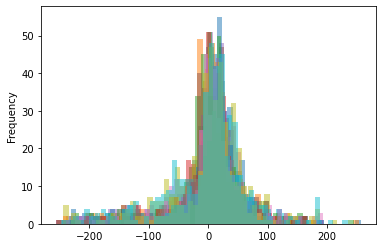

In [52]:
for column in venue_need.columns[1:]:
    #print(column)
    ax = venue_need[column].plot.hist(bins=50, alpha=0.5)





Overall, we can say that the need for venues is roughly normal distributed.
If the value of venue_need exceeds 100, it would be a good business idea to open such a venue in the respective neighborhood.
Lets make a list of these venues:

In [92]:
best_new_venues = pd.DataFrame()

for column in venue_need.columns[1:]:
    
    rslt_df = venue_need[venue_need[column] > 150]
    
    best_new_venues[ str(column)] = rslt_df['List']
    
    print('In the neighborhood:',column)
    
    print(", we recommend to open:")
    
    print(rslt_df['List'])


In the neighborhood: Chinatown
, we recommend to open:
165    Italian Restaurant
224                  Park
294      Sushi Restaurant
326             Wine Shop
Name: List, dtype: object
In the neighborhood: Manhattanville
, we recommend to open:
238        Pizza Place
305    Thai Restaurant
Name: List, dtype: object
In the neighborhood: Central Harlem
, we recommend to open:
165    Italian Restaurant
194    Mexican Restaurant
294      Sushi Restaurant
305       Thai Restaurant
Name: List, dtype: object
In the neighborhood: Upper East Side
, we recommend to open:
159    Ice Cream Shop
224              Park
Name: List, dtype: object
In the neighborhood: Yorkville
, we recommend to open:
156    Hotel
Name: List, dtype: object
In the neighborhood: Lenox Hill
, we recommend to open:
156             Hotel
159    Ice Cream Shop
224              Park
Name: List, dtype: object
In the neighborhood: Upper West Side
, we recommend to open:
140             Gymnastics Gym
141            Harbor / Mari

### Thank you for completing this lab!

This notebook was created by [Alex Aklson](https://www.linkedin.com/in/aklson?cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork-21253531&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ&cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork-21253531&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ) and [Polong Lin](https://www.linkedin.com/in/polonglin?cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork-21253531&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ&cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork-21253531&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ). I hope you found this lab interesting and educational. Feel free to contact us if you have any questions!


This notebook is part of a course on **Coursera** called _Applied Data Science Capstone_. If you accessed this notebook outside the course, you can take this course online by clicking [here](http://cocl.us/DP0701EN_Coursera_Week3_LAB2).


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description         |
| ----------------- | ------- | ------------- | -------------------------- |
| 2020-11-26        | 2.0     | Lakshmi Holla | Updated the markdown cells |
|                   |         |               |                            |
|                   |         |               |                            |

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
